<div class="alert alert-block alert-success">
    
# FIT5196 Task 3 Report in Assessment 2
#### Student Name: Manh Tung Vu, Ilya Bessonov
#### Student ID: 30531438, 34466029

Date: 14/10/2024


# Introduction

This assignment involves working with two distinct datasets to prepare them for analysis and modeling. The first dataset, suburb_info.xlsx, provides key property and demographic information about various suburbs in Melbourne, with the goal of building a linear regression model to predict median house prices based on several attributes. The second dataset, derived from DigiCO, an online electronics retailer in Melbourne, focuses on customer orders and contains transactional data that requires cleansing due to anomalies, missing values, and outliers.

In addition to the technical tasks, this report will also address a reflective component based on feedback received from Week 10 sessions. We will reflect on the suggestions provided during feedback, discuss our tailored solutions and follow-up actions, and explore how these align with the methodology applied in Assignment 2 (A2). This includes providing justifications for our choices, outlining the exploratory data analysis (EDA) conducted post-feedback, and suggesting future improvements or further investigations that could enhance the quality and utility of the data for predictive modeling.

By the end of this assignment, we will have:

1. Investigated and transformed the suburb dataset to meet the assumptions of linear regression.
2. Cleansed the retail dataset to ensure accuracy and reliability, addressing missing data, errors, and outliers.
3. Provided a comprehensive reflective analysis incorporating Week 10 feedback, highlighting key findings and any actions taken based on feedback.
4. Identified interesting insights through EDA, useful for further analysis and decision-making, while proposing potential areas for future work.

The ultimate goal is to prepare high-quality data that facilitates robust, interpretable models in both the property and retail domains, while incorporating reflective learning and continuous improvement.

# Import library and load dataset

We load the data and import library to demonstrate the steps we taken to address feedback from week 10 session and to show evidences.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import datetime as dt
import copy
import re
import matplotlib.pyplot as plt
import seaborn as sns
from math import *
import statsmodels.formula.api as sm
import statsmodels.stats.anova as sms
from sklearn.cluster import KMeans
import itertools
from sklearn.linear_model import LinearRegression
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from scipy.stats import chi2
from scipy.stats import norm
import nltk
import ast
from scipy import stats
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [ ]:
housing = pd.read_excel('/content/drive/Shareddrives/FIT5196_S2_2024/GroupAssessment2/suburb_info.xlsx')
housing.head()

,suburb,number_of_houses,number_of_units,municipality,aus_born_perc,median_income,median_house_price,population
0,ABBOTSFORD,2304,4706,Yarra,68%,"$1,797","$1,299,400",4025
1,ABERFELDIE,1410,453,Moonee Valley,81%,"$1,571","$1,926,600",22442
2,ALBANVALE,1897,138,Brimbank,46%,$907,"$594,200",54005
3,ALBION,1389,1392,Brimbank,52%,$929,"$739,100",30677
4,ALPHINGTON,1729,1099,Darebin,73%,"$1,538","$1,729,600",9227


In [ ]:
df_outliers = pd.read_csv('/content/drive/Shareddrives/FIT5196_S2_2024/GroupAssessment2/student_data/Group044/Group044_outlier_data.csv')
df_outliers.head()

,order_id,customer_id,date,nearest_warehouse,shopping_cart,order_price,delivery_charges,customer_lat,customer_long,coupon_discount,order_total,season,is_expedited_delivery,distance_to_nearest_warehouse,latest_customer_review,is_happy_customer
0,ORD366091,ID0591435935,2019-09-24,Nickolson,"[('Universe Note', 1), ('Thunder line', 2), ('...",9040,57.11,-37.819074,144.965235,5,8645.11,Spring,False,0.3832,horrible product very bad product stop working...,False
1,ORD498812,ID0304466089,2019-06-06,Nickolson,"[('iStream', 2), ('Candle Inferno', 2), ('Luce...",20290,74.86,-37.818224,144.964299,25,15292.36,Winter,True,0.4636,five stars super,True
2,ORD197285,ID0306904051,2019-04-02,Thompson,"[('Lucent 330S', 2), ('Candle Inferno', 1)]",2890,77.85,-37.808411,144.950987,0,2967.85,Autumn,True,0.5864,brgary was very happy to get the same phone th...,True
3,ORD215413,ID6122497854,2019-08-03,Bakers,"[('pearTV', 2), ('Candle Inferno', 2), ('Lucen...",15940,79.22,-37.802289,145.002780,0,16019.22,Winter,True,1.0848,i love the phone!! i love the phone i'm using ...,True
4,ORD253055,ID0635501939,2019-09-18,Thompson,"[('pearTV', 2), ('Alcon 10', 1)]",21570,100.71,-37.815464,144.940294,0,21670.71,Spring,True,0.6720,i just love it! its faster i just love it! its...,True


In [ ]:
# @title Preparing housing dataframe for EDA
# Typecast relevant columns for EDA. Details of this section is in task 2 notebooks
def remove_perc(percent):
    """
    Removes the percentage sign from a string and returns the number as an integer.

    Args:
        percent (str): A string containing a percentage value (e.g., '45%').

    Returns:
        int: The numeric value as an integer (e.g., 45).
    """
    # Extract the numeric portion from the percentage string and convert it to an integer.
    number = re.search(r'([\d\.\,]+)\%', percent).group(1)
    return int(number)

# Apply remove_perc function to 'aus_born_perc'
housing['aus_born_perc'] = housing['aus_born_perc'].apply(remove_perc)

def extract_price_number_v2(price_string):
    """
    Converts a price string (containing a dollar sign and/or commas) into an integer.

    Args:
        price_string (str): A string representing a price (e.g., '$1,200') or a numeric value.

    Returns:
        int: The numeric price value as an integer after removing any dollar signs and commas.
    """
    # Convert the input to a string, if it's not already, and remove commas and the dollar sign.
    price_string = str(price_string).replace(',', '').replace('$', '')

    # Convert the cleaned string to an integer and return it.
    return int(price_string)

housing['median_income'] = housing['median_income'].apply(extract_price_number_v2)

# Apply 'extract_price_number' function to 'median_house_price'
housing['median_house_price'] = housing['median_house_price'].apply(extract_price_number_v2)

In [ ]:
# @title Prepare data and function for outliers section
formula = 'delivery_charges ~ distance_to_nearest_warehouse + is_expedited_delivery + is_happy_customer +\
           _Spring + _Summer + _Autumn + distance_to_nearest_warehouse*_Spring + distance_to_nearest_warehouse*_Summer + distance_to_nearest_warehouse*_Autumn +\
           is_expedited_delivery*_Spring + is_expedited_delivery*_Summer + is_expedited_delivery*_Autumn'

def calculate_regression_and_show(df, formula):

  # Fit the model
  model = sm.ols(formula, data=df).fit()

  # Print the summary of the model
  print(model.summary())

  # Predict delivery charges using the fitted model
  df['predicted_delivery_charges'] = model.predict(df)

  # Create a scatter plot of predicted vs. actual delivery charges
  plt.figure(figsize=(10, 6))
  plt.scatter(df['delivery_charges'], df['predicted_delivery_charges'])
  plt.xlabel('Actual Delivery Charges')
  plt.ylabel('Predicted Delivery Charges')
  plt.title('Predicted vs. Actual Delivery Charges')
  plt.plot([df['delivery_charges'].min(), df['delivery_charges'].max()], [df['delivery_charges'].min(), df['delivery_charges'].max()], 'k--', lw=2)  # Add a diagonal line for reference

  plt.show()
  return model, df


def graph_residuals(model_name, model, df):
    # Calculate the residuals
    residuals = model.resid

    # Create subplots: 1 row, 2 columns
    fig, axs = plt.subplots(1, 2, figsize=(10, 6))

    # Plot the distribution of residuals in the first subplot
    sns.histplot(residuals, kde=True, ax=axs[0])
    axs[0].set_xlabel('Residuals')
    axs[0].set_ylabel('Frequency')
    axs[0].set_title('Distribution of Model Residuals')

    # Q-Q plot in the second subplot
    stats.probplot(residuals, dist="norm", plot=axs[1])
    axs[1].set_title("Q-Q Plot of Residuals")

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

    # Perform Shapiro-Wilk test on residuals
    shapiro_test_residuals = stats.shapiro(residuals)
    print("Shapiro-Wilk Test for Residuals:")
    print(f"Test Statistic: {shapiro_test_residuals.statistic}")
    print(f"P-value: {shapiro_test_residuals.pvalue}")

    if shapiro_test_residuals.pvalue > 0.05:
        print("The residuals are likely normally distributed (fail to reject H0).")
    else:
        print("The residuals are not likely normally distributed (reject H0).")

# Create dummy variables for the 'season' column
season_dummies = pd.get_dummies(df_outliers['season'], prefix='')

# Concatenate the dummy variables with the original DataFrame
df_outliers = pd.concat([df_outliers, season_dummies], axis=1)

# Print the updated DataFrame to verify the encoding
df_outliers.head(3)

,order_id,customer_id,date,nearest_warehouse,shopping_cart,order_price,delivery_charges,customer_lat,customer_long,coupon_discount,...,_Summer,_Winter,_Autumn,_Spring,_Summer,_Winter,_Autumn,_Spring,_Summer,_Winter
0,ORD366091,ID0591435935,2019-09-24,Nickolson,"[('Universe Note', 1), ('Thunder line', 2), ('...",9040,57.11,-37.819074,144.965235,5,...,False,False,False,True,False,False,False,True,False,False
1,ORD498812,ID0304466089,2019-06-06,Nickolson,"[('iStream', 2), ('Candle Inferno', 2), ('Luce...",20290,74.86,-37.818224,144.964299,25,...,False,True,False,False,False,True,False,False,False,True
2,ORD197285,ID0306904051,2019-04-02,Thompson,"[('Lucent 330S', 2), ('Candle Inferno', 1)]",2890,77.85,-37.808411,144.950987,0,...,False,False,True,False,False,False,True,False,False,False


In [ ]:
# Prepare data for cleaning data section
df_dirty = pd.read_csv('/content/drive/Shareddrives/FIT5196_S2_2024/GroupAssessment2/student_data/Group044/Group044_dirty_data.csv')
df_dirty.head()

,order_id,customer_id,date,nearest_warehouse,shopping_cart,order_price,delivery_charges,customer_lat,customer_long,coupon_discount,order_total,season,is_expedited_delivery,distance_to_nearest_warehouse,latest_customer_review,is_happy_customer
0,ORD140525,ID1463620894,2019-04-06,Bakers,"[('pearTV', 2), ('Alcon 10', 1)]",21570,79.45,-37.818897,145.001768,5,20570.95,Autumn,True,1.1454,excellent excellent,True
1,ORD399387,ID1327054087,2019-02-04,Nickolson,"[('Toshika 750', 1), ('Thunder line', 1), ('Al...",24400,71.92,-37.813576,144.964231,0,24471.92,Summer,False,0.7287,five stars very satisfied,True
2,ORD296189,ID2189145408,2019-08-06,Thompson,"[('Thunder line', 1), ('iStream', 1)]",18990,60.40,-37.811758,144.956521,5,2273.90,Winter,True,0.8375,not unlocked this phone is not unlocked!!!!!! ...,False
3,ORD010967,ID0838386042,2019-03-02,Thompson,"[('Lucent 330S', 2), ('Universe Note', 2), ('p...",26430,79.98,-37.802826,144.947994,0,26509.98,Autumn,True,1.0992,will it last? it is new and working great. sha...,True
4,ORD289291,ID6167413244,2019-01-16,Nickolson,"[('Lucent 330S', 2), ('Universe Note', 1), ('i...",10360,93.05,-37.811745,144.972083,5,19602.13,Summer,True,0.7944,NaN,True


In [ ]:
incorrect_dates = 0
incorrect_rows = []
for index, row in df_dirty.iterrows():
  try:
    dt.datetime.strptime(str(row['date']), '%Y-%m-%d')
  except ValueError:
    incorrect_dates += 1
    incorrect_rows.append(index)


# Feedback from week 10

We received the following feedback from week 10 session

1. Suggestion on task 2: open tasks and make sure to provide explanation and justification on model selection/assumption
2. delivery_charges suggestion
3. Verify solutions on shopping_cart, order_price, order_total
4. Ed post on date later, please read
   Ed post:

   *1) Fixing the date:*

   _If the first 2 item in the date are both smaller than 12 thus hard to decide which one is DD which one is MM (e.g. 10-05-2018) . I would say you can safely make the assumption: it's in the DD-MM-YYYY format (Melbourne format), thus you should fix that into YYYY-MM-DD format._

   _If one of the first 2 item are larger than 12, then you know how to fix that._

   _If the date is like '2019-03-04' in which you cannot decide the MM and DD, then please do not fix it._

   *2) Fixing the season:*

   _Please follow the rule of identify season and the 'max 1 anomaly' rule to fix your season._


# Reflection and future improvement

## 1.Suggestion on task 2

The two main goals of this transformation task are
1. Make all features to be on the same scale
2. Make features to have as much linear relationship as possible with the target variable (median_house_price)

We performed EDA, graphed the distribution, and boxplot of all the numerical variables. We see that many of them are skewed, so we decided to do transformation to bring them to as close to normal as possible. Although it is not a strict assumption of linear regression, linear regression usually perform better on normally distributed data.

The question is what transformation to be used. We decided to test out four transformations (boxcox, root, log, and robust scaling). We then graphed the distribution of transformed features and the Q-Q plot of the transformed features to see how closely they are to normal distribution. We also record kurtosis and skewness which are the two metrics to show the deviation from the mean and the symmetry of the distribution. We then perform a Shapiro Wilk test to check whether we can reject the null hypothesis that the transformed feature is normally distributed. If all four transformations lead to the rejection of null hypothesis, we would choose the transformation where the Shapiro test statistics is highest as our "best" transformation. We then take those transformed features and perform a regression.

We did a regression without transformation first the get the baseline of how our model is performing (R2 = 0.33) then we can see if transformation help improve the model. After running the regression with our 'best' transformation which gives R2 = 0.68, we then normalised our transformed features to make them on the same scale (as per assignment specification) and to avoid too large/too small coefficients in our model.

 We also try out different transformations to see if our R2 improve. We found several models with R2 = 0.68 and we choose the leaast transformed model: 'median_house_price_bc ~ population + aus_born_perc + number_of_houses_bc + median_income + number_of_units_bc' where '_bc' means the features have been boxcox transformed. Even though transforming 'median_income' to 'median_income_bc' also produce R2 = 0.68, we want to prioritise the untransformed feature for simplicity. In addition, 'median_income' feature already somewhat resemble the normal distribution: cannot reject null hypothesis in Shapiro Wilk test.

 After selecting the features, we standardized them so that they are on the same scale and to make sure the model doesn't produce too large or too small coefficients. The new regression model after standardization still hold an R2 = 0.68








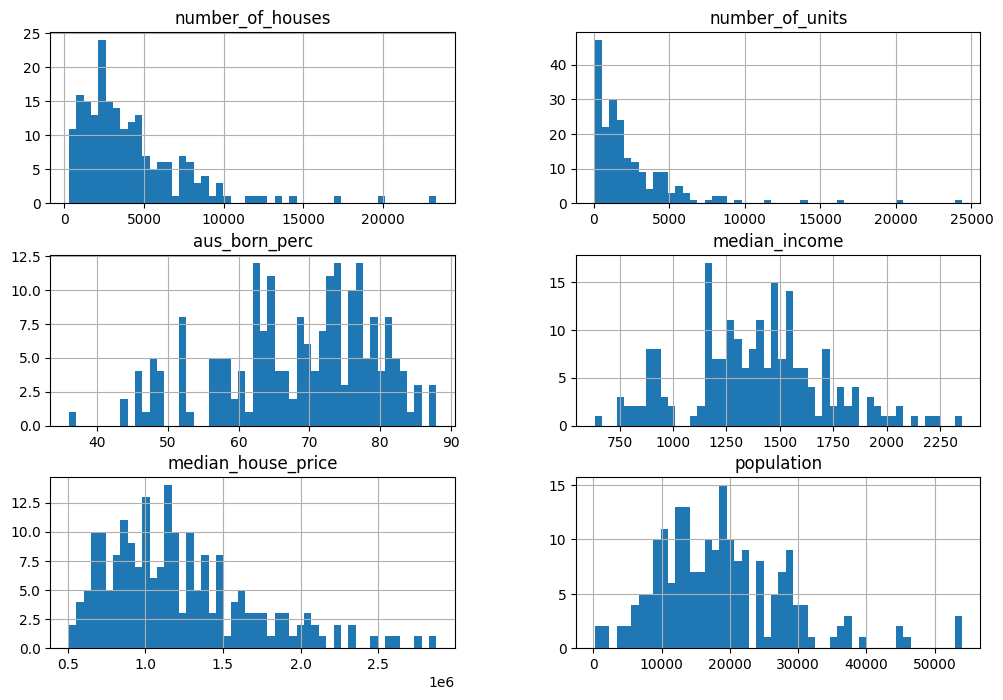

In [ ]:
# EDA
housing.hist(bins = 50, figsize = (12,8))
plt.show()

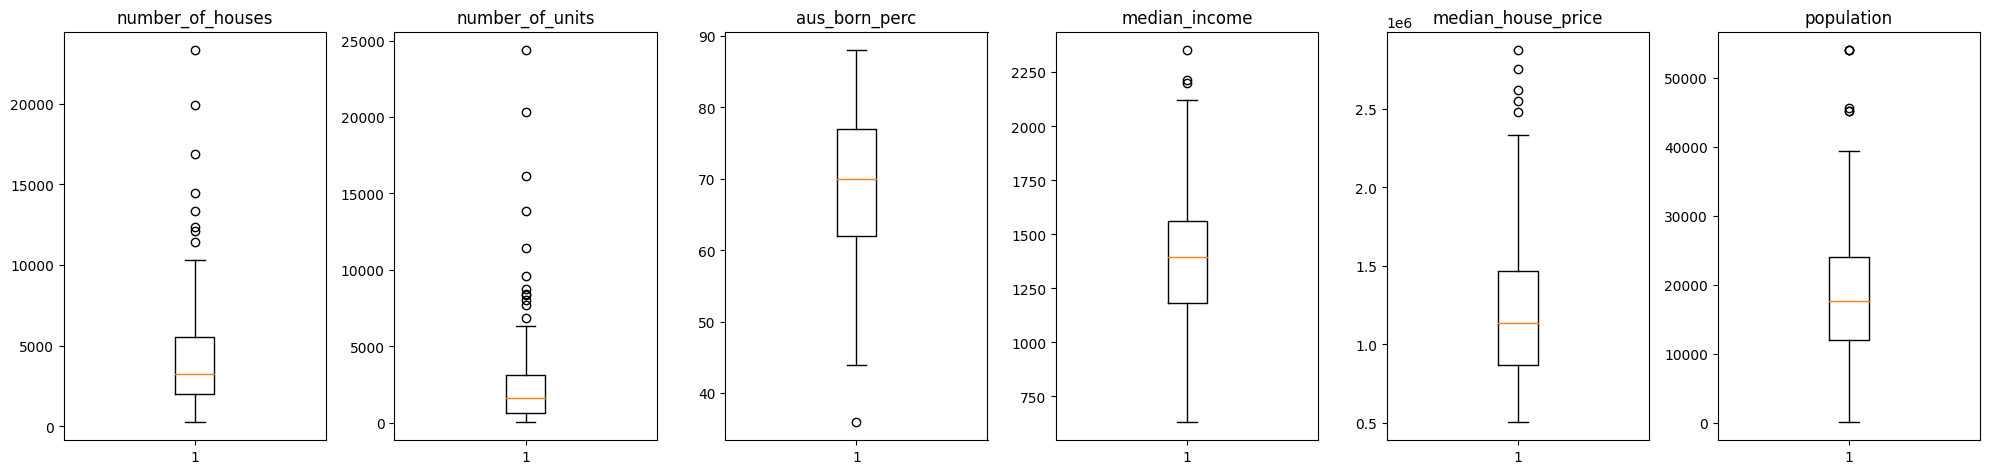

In [ ]:
numerical_features = housing.select_dtypes(include=np.number)

# Create subplots for each numerical feature
fig, axes = plt.subplots(nrows=1, ncols=len(numerical_features.columns), figsize=(20, 5))

for i, column in enumerate(numerical_features.columns):
  axes[i].boxplot(numerical_features[column])
  axes[i].set_title(column)

plt.tight_layout()
plt.show()

## 2.Delivery_charges suggestion [finding outliers]

We received a feedback about how we should present our steps in finding out outliers.

In this section, we use the linear regression model which we built in data cleaning section and verified in missing data section to check for outliers. We take the residuals of all the points and use three methods to check for outliers (i.e. 3sigma rules, Hampel identifiers, and boxplot). An assumption of linear regression is that the distribution of residuals is normal. Thus we decide to choose 3sigma rule: we classified points as outliers if they lies outside of 3 standard deviation from the means residuals.

                            OLS Regression Results                            
Dep. Variable:       delivery_charges   R-squared:                       0.645
Model:                            OLS   Adj. R-squared:                  0.636
Method:                 Least Squares   F-statistic:                     73.67
Date:                Thu, 17 Oct 2024   Prob (F-statistic):          2.96e-101
Time:                        10:37:58   Log-Likelihood:                -1913.9
No. Observations:                 500   AIC:                             3854.
Df Residuals:                     487   BIC:                             3909.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                                    coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------

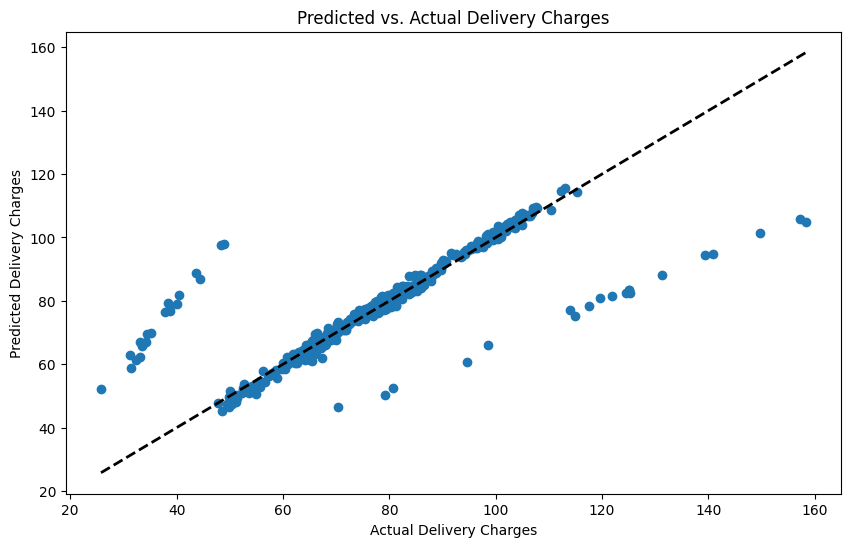

In [ ]:
model, df_ = calculate_regression_and_show(df_outliers, formula)

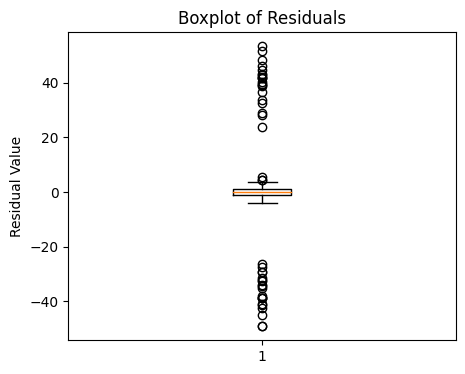

In [ ]:
residuals = model.resid

# Visualise the residuals
plt.figure(figsize=(5, 4))
plt.boxplot(residuals)
plt.title('Boxplot of Residuals')
plt.ylabel('Residual Value')
plt.show()

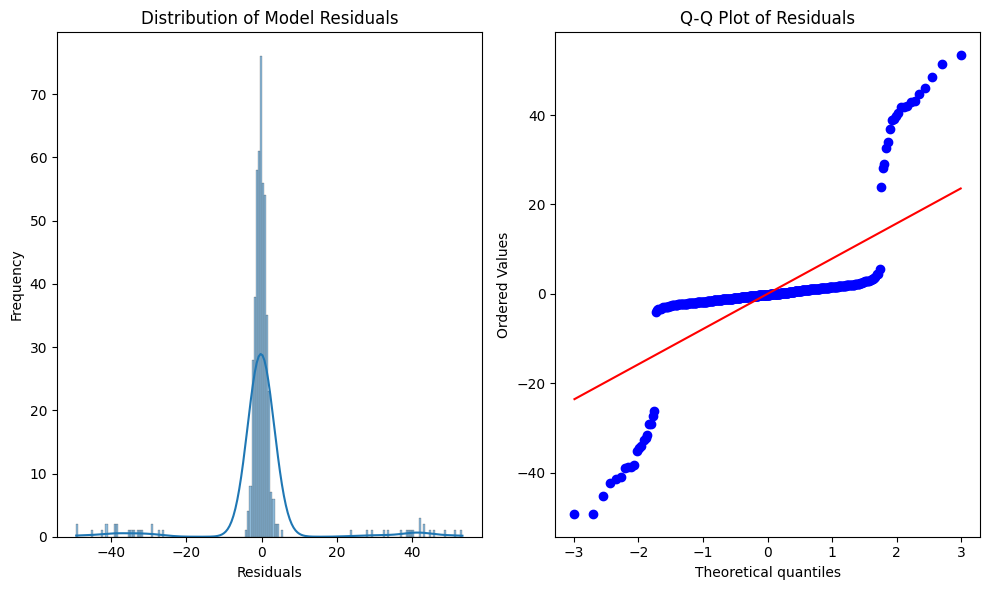

Shapiro-Wilk Test for Residuals:
Test Statistic: 0.5010688907143326
P-value: 3.767262211916988e-35
The residuals are not likely normally distributed (reject H0).


In [ ]:
graph_residuals(model, model, df_)

## 3.Verifying solutions on shopping_cart, order_price, and order_total

We include our verification for shopping_cart, order_price, and order_total by checking there are any discrepencies in order_total and order_price after fixing the cart. The code is shown below



```
# Verify if the order_price and total_price now match
for brand in brands:
  df_cart[brand] = df_cart['shopping_cart_dict'].apply(lambda x: x.get(brand, 0))

df_cart['order_price_chk_2'] = df_cart[brands].dot(prices)
df_cart['order_total_chk_2'] = (df_cart['order_price_chk_2'])*(1 - df_cart['coupon_discount']/100)  + df_cart['delivery_charges']
df_cart['total_diff_2'] = df_cart['order_total'] - df_cart['order_total_chk_2']
df_cart['order_price_diff_2'] = df_cart['order_price'] - df_cart['order_price_chk_2']

filt = (abs(df_cart['total_diff_2']) > 0.001) & (abs(df_cart['order_price_diff_2']) >0.001)
df_cart[filt]
```



We can't show the full code since there are many steps preceeding it. The full code is in task 1 notebook.

We also try to preserve the original order of the shopping_cart list by using an OrderDict and include a function to check our result as below.



```
def check_order_preserved(original_list, processed_list):
    """
    Checks if the order of the second elements in a list of tuples is preserved after processing.

    Args:
        original_list (list): The original list of tuples.
        processed_list (list): The processed list of tuples.

    Returns:
        bool: True if the order of the second elements is preserved, False otherwise.
    """

    # Extract the second element from each tuple in the original list
    original_order = [tup[1] for tup in original_list]

    # Extract the second element from each tuple in the processed list
    processed_order = [tup[1] for tup in processed_list]

    # Compare the original order with the processed order
    return original_order == processed_order

df_cart['order_preserved'] = df_cart.apply(lambda row: check_order_preserved(row['shopping_cart_list'], row['corrected_cart']), axis=1)
df_cart['order_preserved'].value_counts()
```



## 4.Ed post about dates

* Given the information that we can assume Melbourne date format dd-mm-yyyy, we fixed the four rows (168, 313, 398, 400), that we were unsure of whether they are dd-mm-yyy or mm-dd-yyy, to yyyy-mm-dd format.

* With information about there is one error per row, we corrected as many the season as possible based on the dates. Our approach is
  1. Correct the season for lower-case season name since lower-case is the one error in that row
  2. Correct the season for rows where swapping the day and month results in an invalid date.
  3. Correct the season for rows that swapped dates produces an unmatch season.

The process left us with only one rows we could not decide. We then use linear regression to fix this rows. The details of our steps are in task1 notebook.

In [ ]:
print(df_dirty.loc[incorrect_rows, 'date'].tolist())

['2019-29-10', '08-04-2019', '06-05-2019', '07-03-2019', '2019-22-10', '2019-24-11', '2019-22-06', '2019-22-02', '02-12-2019', '03-02-2019', '01-07-2019', '2019-25-12', '2019-18-09', '2019-13-09', '2019-14-06', '07-06-2019', '03-11-2019', '2019-28-06', '08-04-2019', '2019-20-12', '03-07-2019', '10-11-2019', '01-02-2019', '2019-26-01', '2019-18-05', '06-11-2019', '2019-22-03']


In [ ]:
def correct_date(date_string):
    """
    Corrects a date string by ensuring the format is 'YYYY-MM-DD' where:
    - 'YYYY' represents the year.
    - 'MM' is the month (<= 12).
    - 'DD' is the day.

    If both month and day are less than or equal to 12, the function returns the original string.

    Args:
        date_string (str): A string containing a year, month, and day.

    Returns:
        str: A corrected date string in 'YYYY-MM-DD' format, or the original date string if no correction is needed.
    """
    # Extract the year from the date string (a 4-digit number)
    year = re.search(r'\b(\d{4})\b', date_string).group()

    # Find all two-digit numbers (potential month and day)
    month_day_list = re.findall(r'\b(\d{2})\b', date_string)

    # Sort the month and day candidates
    month_day_list = sorted(month_day_list)

    # If both values are <= 12, we assume no correction is needed, so return the original string
    if int(month_day_list[0]) <= 12 and int(month_day_list[1]) <= 12:
        return date_string
    else:
        # Otherwise, the first value is the month, and the second value is the day
        month = month_day_list[0]
        day = month_day_list[1]
        return year + '-' + month + '-' + day


df_dirty.loc[incorrect_rows, 'date'] = df_dirty.loc[incorrect_rows, 'date'].apply(correct_date)

In [ ]:
incorrect_dates_after_fix_1 = 0
incorrect_rows_after_fix_1 = []
for index, row in df_dirty.iterrows():
  try:
    dt.datetime.strptime(str(row['date']), '%Y-%m-%d')
  except ValueError:
    incorrect_dates_after_fix_1 += 1
    incorrect_rows_after_fix_1.append(index)

print("Number of incorrect formatted dates:", incorrect_dates_after_fix_1)
print("Rows with incorrect formatted dates:", incorrect_rows_after_fix_1)

Number of incorrect formatted dates: 13
Rows with incorrect formatted dates: [97, 110, 112, 168, 170, 194, 313, 342, 365, 388, 398, 400, 464]


In [ ]:
# Dictionary that defines the months for each season.
season_dict = {'Spring': [9, 10, 11],  # Spring includes September, October, November
               'Summer': [12, 1, 2],   # Summer includes December, January, February
               'Autumn': [3, 4, 5],    # Autumn includes March, April, May
               'Winter': [6, 7, 8]}    # Winter includes June, July, August

def correct_date_based_on_season(date_string, season):
    """
    Corrects a date string by verifying that the month corresponds to the specified season.
    The function assumes that the year is always correct. The month and day are inferred from the date string
    and checked against the months that belong to the provided season.

    If one of the month/day values matches the season, it assumes that value is the correct month
    and formats the date as 'YYYY-MM-DD'. If neither value matches the season, the original string is returned.

    Args:
        date_string (str): A string containing a year, month, and day.
        season (str): The season for which the date should be validated. Must be one of 'Spring', 'Summer', 'Autumn', or 'Winter'.

    Returns:
        str: A corrected date string in 'YYYY-MM-DD' format, or the original date string if no correction is needed.
    """
    # Extract the year from the date string (a 4-digit number)
    year = re.search(r'\b(\d{4})\b', date_string).group()

    # Find all two-digit numbers (potential month and day)
    month_day_list = re.findall(r'\b(\d{2})\b', date_string)

    # Convert month and day candidates to integers
    month_day_list = [int(x) for x in month_day_list]

    # Get the list of months that belong to the specified season
    season_months = season_dict[season]

    # Check if both month and day are in the season's valid months
    if (month_day_list[0] in season_months) and (month_day_list[1] in season_months):
        return date_string  # No correction needed, return original string
    # If the first value matches the season, assume it is the correct month
    elif month_day_list[0] in season_months:
        month = month_day_list[0]
        day = month_day_list[1]
        return year + '-' + str(month) + '-' + str(day)
    # If the second value matches the season, assume it is the correct month
    elif month_day_list[1] in season_months:
        month = month_day_list[1]
        day = month_day_list[0]
        return year + '-' + str(month) + '-' + str(day)
    else:
        return date_string  # No valid month found, return the original string

df_dirty.loc[incorrect_rows_after_fix_1, 'date'] = df_dirty.loc[incorrect_rows_after_fix_1].apply(lambda row: correct_date_based_on_season(row['date'], row['season']), axis=1)

In [ ]:
incorrect_dates_after_fix_2 = 0
incorrect_rows_after_fix_2 = []
for index, row in df_dirty.iterrows():
  try:
    dt.datetime.strptime(str(row['date']), '%Y-%m-%d')
  except ValueError:
    incorrect_dates_after_fix_2 += 1
    incorrect_rows_after_fix_2.append(index)

print("Number of incorrect formatted dates:", incorrect_dates_after_fix_2)
print("Rows with incorrect formatted dates:", incorrect_rows_after_fix_2)

Number of incorrect formatted dates: 4
Rows with incorrect formatted dates: [168, 313, 398, 400]


In [ ]:
df_dirty.loc[incorrect_rows_after_fix_2, ['date', 'season']]

,date,season
168,02-12-2019,Summer
313,07-06-2019,Winter
398,10-11-2019,Spring
400,01-02-2019,Summer


Thanks to the new information about date, we can fix these rows with certainty.

# Reference

1. pandas:
McKinney, W. (2010). Data Structures for Statistical Computing in Python. Proceedings of the 9th Python in Science Conference, 51-56. https://doi.org/10.25080/Majora-92bf1922-00a
2. Matplotlib:
Hunter, J. D. (2007). Matplotlib: A 2D Graphics Environment. Computing in Science & Engineering, 9(3), 90-95. https://doi.org/10.1109/MCSE.2007.55
3. re:
Python Software Foundation. (n.d.). re — Regular expression operations. Retrieved from https://docs.python.org/3/library/re.html
4. numpy:
Harris, C. R., Millman, K. J., van der Walt, S. J., et al. (2020). Array programming with NumPy. Nature, 585(7825), 357-362. https://doi.org/10.1038/s41586-020-2649-2
5. seaborn:
Waskom, M. L. (2021). Seaborn: Statistical Data Visualization. Journal of Open Source Software, 6(60), 3021. https://doi.org/10.21105/joss.03021
6. statsmodels:
Seabold, S., & Perktold, J. (2010). Statsmodels: Econometric and Statistical Modeling with Python. Proceedings of the 9th Python in Science Conference, 57-61. https://doi.org/10.25080/Majora-92bf1922-011
7. scipy:
Virtanen, P., Gommers, R., Oliphant, T. E., et al. (2020). SciPy 1.0: Fundamental Algorithms for Scientific Computing in Python. Nature Methods, 17, 261-272. https://doi.org/10.1038/s41592-019-0686-2
8. scikit-learn (RobustScaler):
Pedregosa, F., Varoquaux, G., Gramfort, A., et al. (2011). Scikit-learn: Machine Learning in Python. Journal of Machine Learning Research, 12, 2825-2830. https://jmlr.org/papers/v12/pedregosa11a.html

We acknowledge the use of Gen-AI (ChatGPT, Copylot and Gemini) to get some hints about specific Python libraries/functions/classes/methods/options/settings. Every information from AI has been found and double-checked in the original library manuals.  